In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import matplotlib.pyplot as plt

In [2]:
batchsize = 64
imagesize = 128
train= tf.keras.preprocessing.image_dataset_from_directory(
    "../archive/train/",
    shuffle = True,
    image_size = (imagesize,imagesize),
    batch_size = batchsize
)
test= tf.keras.preprocessing.image_dataset_from_directory(
    "../archive/test/",
    shuffle = True,
    image_size = (imagesize,imagesize),
    batch_size =batchsize
)

Found 15557 files belonging to 23 classes.
Found 4002 files belonging to 23 classes.


In [3]:
print(len(train))
print(len(test))

244
63


In [4]:
type(train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [5]:
class_names = train.class_names
class_names

['Acne and Rosacea Photos',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis Photos',
 'Bullous Disease Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Eczema Photos',
 'Exanthems and Drug Eruptions',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs Photos',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Urticaria Hives',
 'Vascular Tumors',
 'Vasculitis Photos',
 'Warts Molluscum and other Viral Infections']

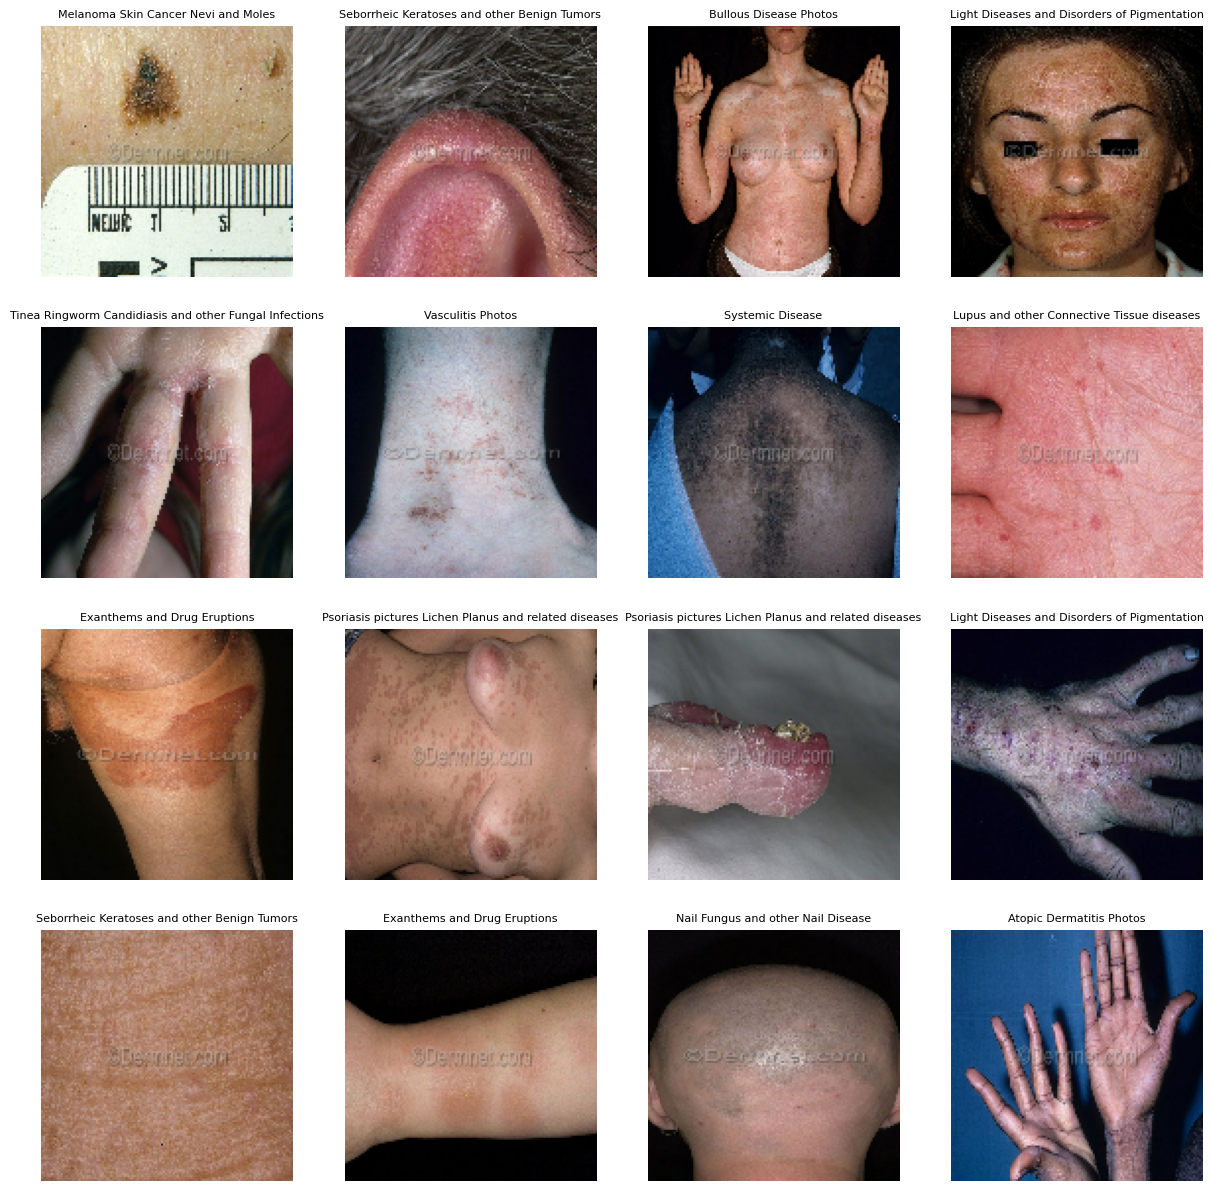

In [6]:
plt.figure(figsize = (15,15))
for image_batch, label_batch in train.take(1):
    for j in range(16):
        ax = plt.subplot(4,4,j+1)
        plt.imshow(image_batch[j].numpy().astype("uint8"))
        plt.title(class_names[label_batch[j]],fontsize = 8)
        plt.axis("off")

In [7]:
def dataset_partitions(ds, train_split = 0.9,val_split = 0.1,shuffle = True,shuffle_size =10000):
    assert(train_split+val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 24)
    train_size = int(train_split*ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    return train_ds, val_ds

In [8]:
train_ds, val_ds =dataset_partitions(train)

In [9]:
len(val_ds)

24

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resizerescale = tf.keras.Sequential([
                     keras.layers.experimental.preprocessing.Resizing(imagesize,imagesize),
                     keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
augmentation = tf.keras.Sequential([
                     keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
model = models.Sequential([
                           resizerescale,
                           layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (batchsize,imagesize,imagesize,3) ),
                           layers.AveragePooling2D((2,2)),
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.AveragePooling2D((2,2)), 
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.AveragePooling2D((2,2)),    
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.AveragePooling2D((2, 2)),
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.AveragePooling2D((2, 2)),    
                           layers.Flatten(),
                           layers.Dense(128, activation='relu'),
                           layers.Dense(23, activation='softmax')
])
model.build(input_shape = (batchsize,128,128,3))

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 126, 126, 64)        1792      
                                                                 
 average_pooling2d (AverageP  (64, 63, 63, 64)         0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (64, 61, 61, 128)         73856     
                                                                 
 average_pooling2d_1 (Averag  (64, 30, 30, 128)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (64, 28, 28, 128)        

In [18]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
epoch = 100
history = model.fit(
    train_ds,
    epochs = epoch,
    batch_size = batchsize,
    validation_data = val_ds,
    verbose = 1,
) 

Epoch 1/100
219/219 [==============================] - 1643s 7s/step - loss: 2.9914 - accuracy: 0.0880 - val_loss: 2.9596 - val_accuracy: 0.1230
Epoch 2/100
219/219 [==============================] - 1339s 6s/step - loss: 2.9145 - accuracy: 0.1276 - val_loss: 2.8171 - val_accuracy: 0.1484
Epoch 3/100
219/219 [==============================] - 1274s 6s/step - loss: 2.8343 - accuracy: 0.1497 - val_loss: 2.7973 - val_accuracy: 0.1615
Epoch 4/100
219/219 [==============================] - 1266s 6s/step - loss: 2.7884 - accuracy: 0.1634 - val_loss: 2.7455 - val_accuracy: 0.1777
Epoch 5/100
219/219 [==============================] - 1219s 6s/step - loss: 2.7491 - accuracy: 0.1761 - val_loss: 2.6958 - val_accuracy: 0.2012
Epoch 6/100
219/219 [==============================] - 1209s 6s/step - loss: 2.7161 - accuracy: 0.1859 - val_loss: 2.6865 - val_accuracy: 0.1960
Epoch 7/100
219/219 [==============================] - 1203s 5s/step - loss: 2.6839 - accuracy: 0.1985 - val_loss: 2.6552 - val_ac

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

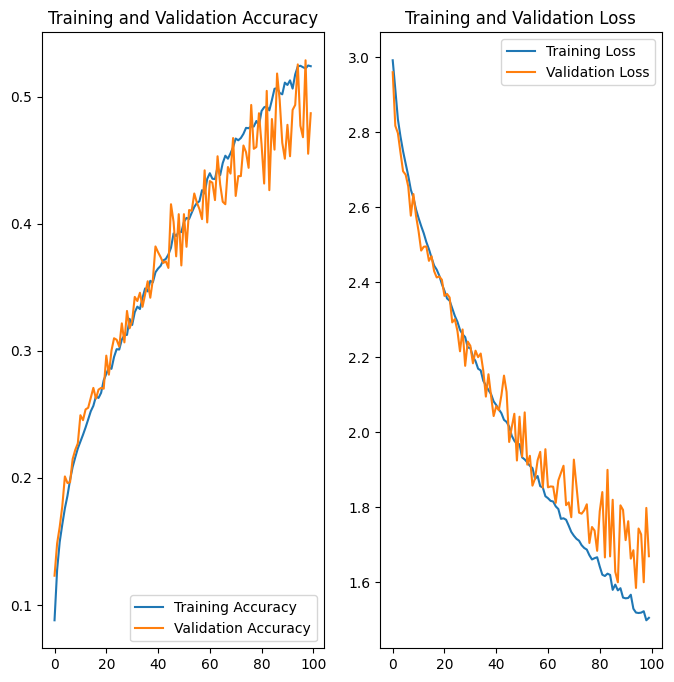

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epoch), acc, label='Training Accuracy')
plt.plot(range(epoch), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epoch), loss, label='Training Loss')
plt.plot(range(epoch), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Nail Fungus and other Nail Disease
2/2 [==============================] - 2s 845ms/step
predicted label: Atopic Dermatitis Photos


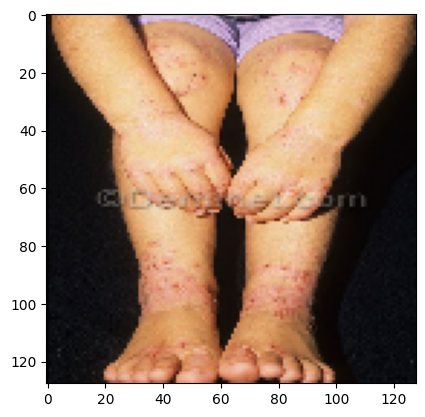

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[23].numpy().astype('uint8')
    first_label = labels_batch[25].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[23])])

In [27]:
def predict(model, img):
    img_array = tf.keras.utils.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 91ms/step


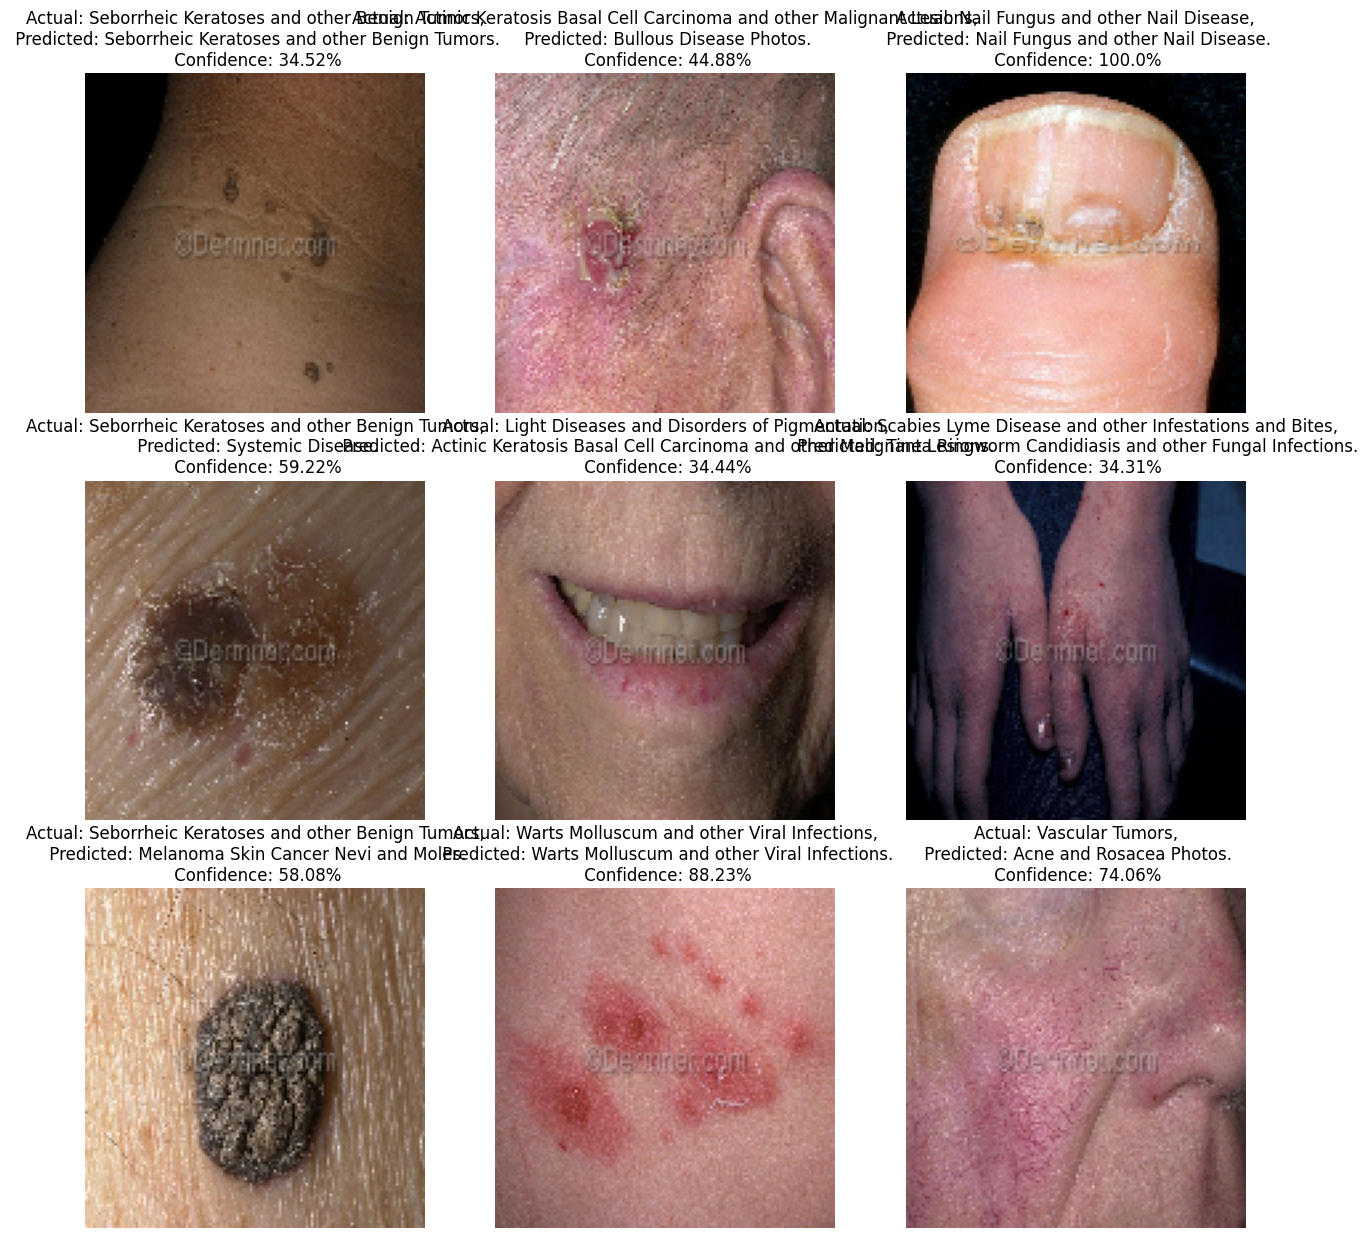

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [53]:
#!mkdir -p saved_model
#model.save('saved_model/my_model')
#new_model.save("../archive/first_300+50.h5",save_format='h5')
model.save('Final_model.h5')

In [49]:
from keras.models import load_model

In [54]:
#new_model = load_model("/kaggle/input/models/first_25050.h5")
model = keras.models.load_model('model.h5')

In [56]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
epoch = 50
history = model.fit(
    train_ds,
    epochs = epoch,
    batch_size = batchsize,
    validation_data = val_ds,
    verbose = 1,
) 

2/2 [==============================] - 2s 796ms/step
predicted label: Cellulitis Impetigo and other Bacterial Infections


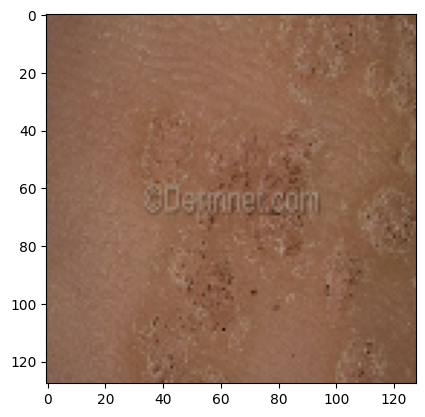

In [67]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[23].numpy().astype('uint8')
    first_label = labels_batch[25].numpy()
    
    
    plt.imshow(first_image)
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[23])])

   